In [79]:
# Detect Multicollinearity 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns


In [80]:
# 1. heatmap for pairwise correlations

credit = pd.read_csv("../Data/Credit.csv")
credit['Income'] = pd.to_numeric(credit['Income'])
credit.sample(5)

Unnamed: 0  Income  Limit  Rating  Cards  Age  Education  Gender Student  \
196         197  93.039   7398     517      1   67         12    Male      No   
195         196  23.883   5384     398      2   73         16  Female      No   
269         270  39.055   5565     410      4   48         18  Female      No   
346         347  21.551   5380     420      5   51         18    Male      No   
38           39  11.795   3899     300      4   25         10  Female      No   

    Married         Ethnicity  Balance  
196     Yes  African American      749  
195     Yes  African American      802  
269     Yes         Caucasian      772  
346     Yes             Asian      907  
38       No         Caucasian      531

In [81]:
quantitative_vars = [ 'Balance', 'Income', 'Limit', 'Rating', 'Cards', 'Age']

# Calculate the correlation matrix
corr_matrix = credit[quantitative_vars].corr()
corr_matrix

Balance    Income     Limit    Rating     Cards       Age
Balance  1.000000  0.463656  0.861697  0.863625  0.086456  0.001835
Income   0.463656  1.000000  0.792088  0.791378 -0.018273  0.175338
Limit    0.861697  0.792088  1.000000  0.996880  0.010231  0.100888
Rating   0.863625  0.791378  0.996880  1.000000  0.053239  0.103165
Cards    0.086456 -0.018273  0.010231  0.053239  1.000000  0.042948
Age      0.001835  0.175338  0.100888  0.103165  0.042948  1.000000

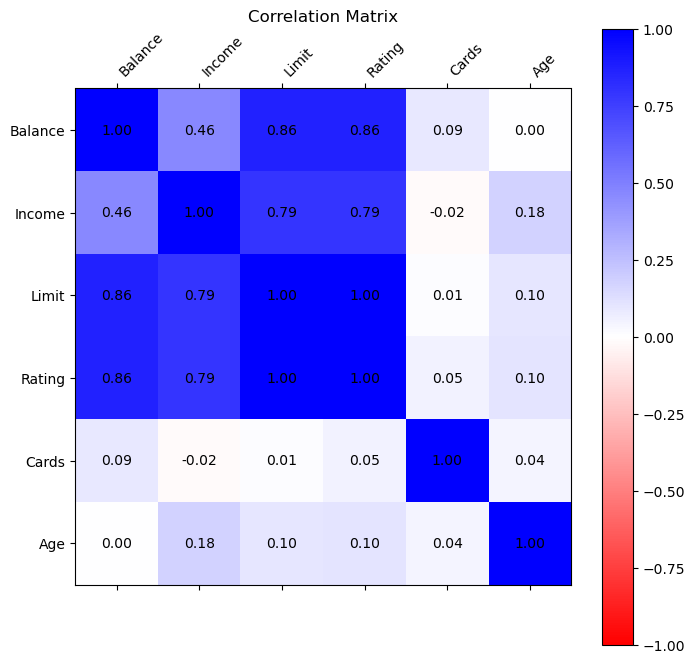

In [82]:
import matplotlib.colors as mcolors

# Create a custom diverging colormap where 0 is explicitly white
cmap = mcolors.LinearSegmentedColormap.from_list('custom_coolwarm', ['red', 'white', 'blue'], N=256)

# Create a plot to visualize the correlation matrix with white for zero
fig, ax = plt.subplots(figsize=(8, 8))

# Apply the custom colormap to the heatmap
cax = ax.matshow(corr_matrix, cmap=cmap, vmin=-1, vmax=1)

# Add color bar to the side
plt.colorbar(cax)

# Set the ticks for the x and y axis
ax.set_xticks(range(len(quantitative_vars)))
ax.set_yticks(range(len(quantitative_vars)))

# Set the labels for the ticks
ax.set_xticklabels(quantitative_vars, rotation=45, ha='left')
ax.set_yticklabels(quantitative_vars)

# Annotate the correlation matrix with the numeric values
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Display the plot
plt.title("Correlation Matrix")
plt.show()


### Note:

- Must filter to quantitative variables... 
- Think: how can we measure the "correlation" between categorical variables? or categorical variables vs. quantitative variables? Not straightforward always.

### Problem with identifying with correlations:
- It characterizes pairwise relationships, but does not evaluate all features' joint correlations together.
- It doesn't make sense out of the box for categorical variables. 

In [84]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices #an alternative to basic pandas dfs.

y, X = dmatrices('Balance ~ Income + Limit + Rating + Cards + \
                  Age + Education + Gender + Student + Married + Ethnicity', 
                  data=credit, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                features
0    52.451853               Intercept
1     1.005849        Gender[T.Female]
2     1.031517          Student[T.Yes]
3     1.044638          Married[T.Yes]
4     1.552157      Ethnicity[T.Asian]
5     1.527504  Ethnicity[T.Caucasian]
6     2.786182                  Income
7   234.028100                   Limit
8   235.848259                  Rating
9     1.448690                   Cards
10    1.051410                     Age
11    1.019588               Education


Limit and Rating are identified as variables that are causing the multicolinearity problem. Since they are highly correlated, we can consider deleting one. Let's try to delete Limit.

In [86]:
#deleting limit improves VIFs considerably
y, X_new = dmatrices('Balance~ Income + Rating + Cards + \
                      Age + Education + Gender + Student + Married + Ethnicity', 
                      data=credit, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

# The intercept has a high VIF but this doesn't mean we should necessarily get rid of it. 
# If we do, we are assuming true proportionality between X and y... that's a big assumption. 
# Especially since from the summary table that it's not close to zero. 
# Btw - what are the null and alt hypotheses for that t - test? Do you remember? 

    VIF Factor                features
0    46.513331               Intercept
1     1.005848        Gender[T.Female]
2     1.022092          Student[T.Yes]
3     1.032237          Married[T.Yes]
4     1.546515      Ethnicity[T.Asian]
5     1.527415  Ethnicity[T.Caucasian]
6     2.784966                  Income
7     2.730561                  Rating
8     1.019639                   Cards
9     1.051135                     Age
10    1.013503               Education


In [87]:
# fit initial model 
model = smf.ols('Balance ~ Income + Rating + Cards + \
                Age + Education + Gender + Student + Married + Ethnicity', data=credit).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     757.8
Date:                Thu, 19 Sep 2024   Prob (F-statistic):          4.46e-248
Time:                        08:21:05   Log-Likelihood:                -2415.4
No. Observations:                 400   AIC:                             4853.
Df Residuals:                     389   BIC:                             4897.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -549.3140     35.085    -15.657      0.000    -618.293    -480.335
Gender[T.Female]         -10.7106     10.325     -1.037      0.300     -31.010       9.589
Student[T.Yes]           416.4376     17.336     24.021      0.000     382.353     450.522
Married[T.Yes]           -15.1096     10.728     -1.408      0.160     -36.202       5.983
Ethnicity[T.Asian]        21.7616     14.678      1.483      0.139      -7.096      50.619
Ethnicity[T.Caucasian]    10.6492     12.716      0.837      0.403     -14.351      35.649
Income                    -7.7746      0.244    -31.878      0.000      -8.254      -7.295
Rating                     3.9790      0.055     72.332      0.000       3.871       4.087
Cards                      3.9654      3.793      1.045      0.296      -3.492      11.422
Age                       -0.6416      0.306     -2.096      0.037      -1.243      -0.040
Education                 -0.3799      1.659     -0.229      0.819      -3.642       2.882
==============================================================================
Omnibus:                       15.651   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.769
Skew:                           0.490   Prob(JB):                     0.000228
Kurtosis:                       2.789   Cond. No.                     2.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Influential points


In [89]:
#object for the analysis of influential points
infl = model.get_influence()
#members
print(dir(infl)) #these are all the things inside the infl variable

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_drop_vari', '_ols_xnoti', '_plot_index', '_res_looo', 'aux_regression_endog', 'aux_regression_exog', 'cooks_distance', 'cov_ratio', 'det_cov_params_not_obsi', 'dfbeta', 'dfbetas', 'dffits', 'dffits_internal', 'endog', 'ess_press', 'exog', 'get_resid_studentized_external', 'hat_diag_factor', 'hat_matrix_diag', 'influence', 'k_vars', 'model_class', 'nobs', 'params_not_obsi', 'plot_index', 'plot_influence', 'resid', 'resid_press', 'resid_std', 'resid_studentized', 'resid_studentized_external', 'resid_studentized_internal', 'resid_var', 'results', 'scale', 'sigma2_not_obsi', 'summary_frame', 'summary_table']


In [90]:
#externally studentized residuals
print(infl.resid_studentized_external[1:5]) #just the first 5 obs as example

[-0.11133069 -0.89373531 -0.34074765 -0.5816827 ]


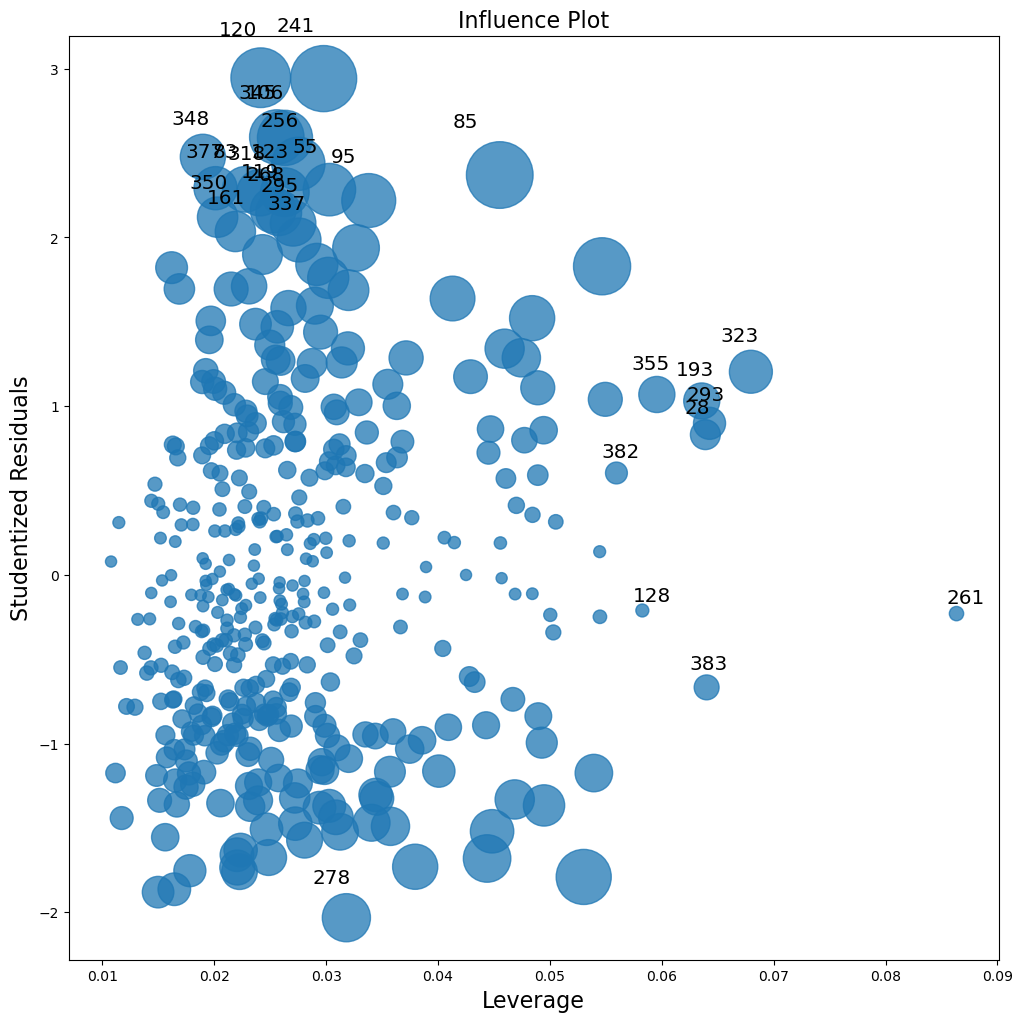

In [91]:
#graphical representation of the influence of each observation
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model, ax=ax, criterion="cooks") 
#size of points are given by cook's dist value
#the points with massive size whose studentized resids lie outside the range from (-3,3) should raise a "yellow" flag

### Thresholding externally studentized residuals


In [93]:
import scipy
n=400
p=11

tstar_stud = scipy.stats.t.ppf(0.975,df=n-p-1) # t quantile at 97.5 %ile
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > tstar_stud
#which ones?
print(credit.index[atyp_stud],reg_studs[atyp_stud])

Index([ 55,  83,  85,  95, 106, 119, 120, 123, 161, 241, 256, 268, 278, 295,
       318, 337, 345, 348, 350, 377],
      dtype='int64') [ 2.28363253  2.28558871  2.37028027  2.21911588  2.59050845  2.16225126
  2.94701144  2.26873769  2.03549831  2.9417433   2.43680305  2.14677707
 -2.03173247  2.08414568  2.2657838   1.98497377  2.59557321  2.47831419
  2.12056825  2.29228244]


In [94]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(credit.index[atyp_cook],reg_cook[atyp_cook])

Index([ 55,  62,  83,  85,  95,  96, 102, 106, 119, 120, 121, 123, 222, 241,
       242, 256, 268, 278, 295, 318, 320, 337, 345, 348],
      dtype='int64') 55     0.014648
62     0.011448
83     0.010944
85     0.024069
95     0.015506
96     0.017486
102    0.010466
106    0.016248
119    0.010913
120    0.019160
121    0.010675
123    0.012506
222    0.010672
241    0.023672
242    0.011871
256    0.015080
268    0.010974
278    0.012229
295    0.010881
318    0.011399
320    0.016217
337    0.010079
345    0.015846
348    0.010658
Name: cooks_d, dtype: float64


#### These observations should be looked at more carefully. Consider both including/excluding points and see if it has a large difference on your model/coefs. 
